# Keras Upgrade

In [10]:
#!pip install keras-nightly

# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [11]:
#!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import io

## Data Loading

In [13]:
data = io.loadmat('notMNIST_small.mat')

data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 10 11:38:32 2011',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   1.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 215., ...,   0., 160., 124.],
         [255.,   0., 227., ...,   0., 122.,  72.],
         [255.,   0., 156., ...,   0.,   0.,  12.]],
 
        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,  19.,   0., ...,   0.,   0.,   0.],
         [  0.,  93.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 255., ...,   0., 255., 255.],
         [255.,   0., 110., ...,   0., 206., 227.],
         [255.,   0.,  21., ...,   0.,   0.,  63.]],
 
        [[  0.,   3.,   0., ...,   0.,   0.,   0.],
         [  0., 167.,   0., ...,   0.,   0.,   0.],
         [  0., 255.,   0., ...,   1.,   1.,   0.],
         ...,
         [255.,   0., 223.

In [14]:
x = data['images']
y = data['labels']

In [15]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [16]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [17]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

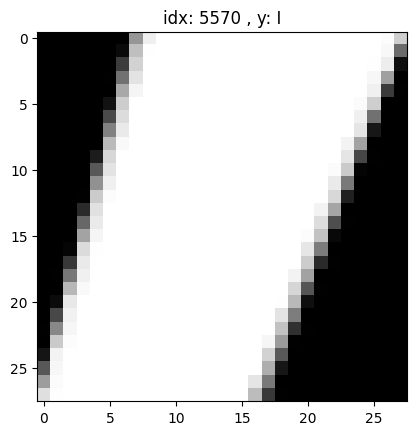

In [18]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='gray' )
plt.show()

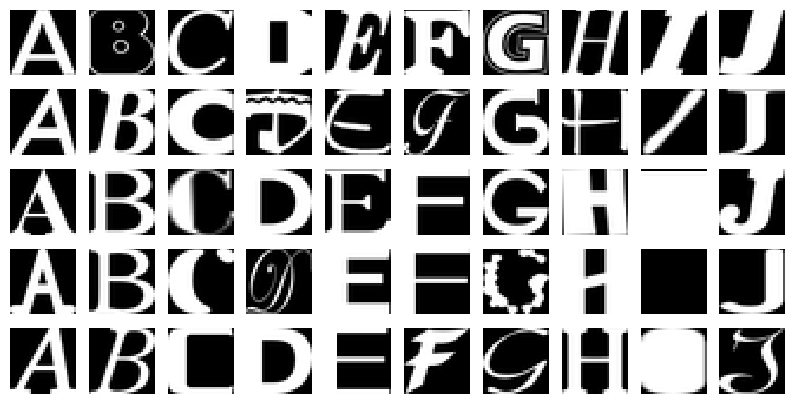

In [19]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='gray', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split

    - training set : test set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [20]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024)

In [21]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((14979, 28, 28, 1), (14979,), (3745, 28, 28, 1), (3745,))

* Scaling

    - min-max scaling

In [22]:
max_n, min_n = train_x.max(), train_x.min()

In [23]:
train_x_mm = (train_x - min_n) / (max_n - min_n)
test_x_mm = (test_x - min_n) / (max_n - min_n)

# train_x_mm = train_x / 255.0
# test_x_mm = test_x / 255.0

In [24]:
train_x_mm.max(), train_x_mm.min()

(1.0, 0.0)

* One-hot encoding

In [25]:
from keras.utils import to_categorical

In [26]:
classes_n = len(np.unique(train_y))

In [27]:
train_y_cat = to_categorical(train_y, classes_n)
test_y_cat = to_categorical(test_y, classes_n)

* Data shape 재확인

In [28]:
train_x_mm.shape, train_y_cat.shape

((14979, 28, 28, 1), (14979, 10))

## Modeling
- 조건
    1. Sequential API, Functional API 중 택일
    2. Flatten Layer 사용할 것
    3. Activation Function이 주어진 Dense Layer 뒤에 BatchNormalization 사용할 것
    4. Dropout을 0.2 정도로 사용할 것
    5. Early Stopping을 사용할 것

In [30]:
import keras

keras.__version__

'3.6.0.dev2024101603'

In [31]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout

#clear_session()
keras.utils.clear_session()

model=Sequential([Input(shape=(28,28,1)),
                  Flatten(),
                  Dense(128,activation='relu'),
                  BatchNormalization(),
                  Dropout(0.2),
                  Dense(64, activation='relu'),
                  BatchNormalization(),
                  Dropout(0.2),
                  Dense(32, activation='relu'),
                  BatchNormalization(),
                  Dropout(0.2),
                  Dense(10,activation='softmax')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,042 (437.66 KB)

 Trainable params: 111,594 (435.91 KB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
## compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

* Early stopping

In [33]:
from keras.callbacks import EarlyStopping

In [34]:
es = EarlyStopping(monitor='val_loss',        ## 얼리스토핑을 적용할 관측 지표
                   min_delta=0,               ## threshold. 이 값보다 더 크게 지표가 변화해야 성능 개선으로 간주!
                   patience=3,                ## 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                   verbose=1,                 ## 얼리스토핑이 적용된 epoch 알려줌
                   restore_best_weights=True, ## 최적의 가중치를 모델에 다시 전달
                   )

* .fit( )

In [35]:
hist = model.fit(train_x_mm, train_y_cat, validation_split=0.2,
                 epochs=10000, verbose=1,
                 callbacks=[es],
                 )

Epoch 1/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.5946 - loss: 1.3181 - val_accuracy: 0.8755 - val_loss: 0.4235
Epoch 2/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8535 - loss: 0.5329 - val_accuracy: 0.8768 - val_loss: 0.4196
Epoch 3/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8666 - loss: 0.4828 - val_accuracy: 0.8982 - val_loss: 0.3457
Epoch 4/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8752 - loss: 0.4381 - val_accuracy: 0.9039 - val_loss: 0.3304
Epoch 5/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8889 - loss: 0.3909 - val_accuracy: 0.9005 - val_loss: 0.3296
Epoch 6/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8912 - loss: 0.3823 - val_accuracy: 0.9045 - val_loss: 0.3194
Epoch 7/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8975 - loss: 0.3584 - val_accuracy: 0.9029 - val_loss: 0.3282
Epoch 8/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9034 - loss:

* .evaluate( )

In [38]:
model.evaluate(test_x_mm, test_y_cat)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9198 - loss: 0.2745


[0.2940342426300049, 0.9161548614501953]

* .predict( )

In [39]:
y_pred = model.predict(test_x_mm)
y_pred[:3]

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[9.98930156e-01, 3.88942753e-05, 2.77436520e-05, 1.21300973e-05,
        7.99134796e-05, 4.68592916e-05, 1.05842635e-04, 2.52803904e-04,
        3.46179557e-04, 1.59345363e-04],
       [1.02881785e-03, 4.62412089e-03, 4.05470282e-03, 3.47227720e-03,
        7.82948732e-03, 9.52347577e-01, 7.74477562e-03, 4.51860763e-03,
        6.33297954e-03, 8.04670900e-03],
       [1.89254453e-04, 1.88447337e-03, 7.62814772e-04, 9.94583666e-01,
        1.33872862e-04, 7.27610255e-04, 3.41193198e-04, 3.57344652e-05,
        9.26173234e-04, 4.15182760e-04]], dtype=float32)

In [40]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y_cat, axis=1)

In [41]:
y_pred_arg.shape
y_pred_arg[:5]

array([0, 5, 3, 2, 1])

* 평가 지표

In [42]:
from sklearn.metrics import classification_report

In [43]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F',' G', 'H', 'I', 'J']

print( classification_report(test_y_arg, y_pred_arg, target_names=class_names) )

              precision    recall  f1-score   support

           A       0.96      0.90      0.93       360
           B       0.92      0.91      0.92       382
           C       0.94      0.94      0.94       385
           D       0.89      0.94      0.91       373
           E       0.92      0.90      0.91       364
           F       0.89      0.96      0.92       392
           G       0.91      0.89      0.90       390
           H       0.93      0.92      0.92       364
           I       0.93      0.85      0.89       360
           J       0.89      0.96      0.92       375

    accuracy                           0.92      3745
   macro avg       0.92      0.92      0.92      3745
weighted avg       0.92      0.92      0.92      3745



## Visualization

* 실제 데이터 확인

idx = 3254
해당 인덱스의 이미지는 C
모델의 예측 : C
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 99.0
D 0.0
E 0.0
F 0.0
G 0.0
H 0.0
I 0.0
J 0.0
정답


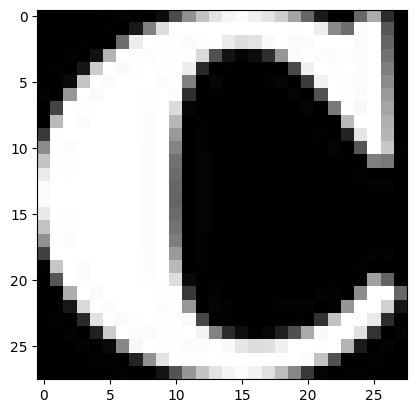

In [44]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()

* 틀린 이미지만 확인해보기

In [45]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

314

idx = 2273
해당 인덱스의 이미지는 J
모델의 예측 : F
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 0.0
D 0.0
E 1.0
F 96.0
G 0.0
H 1.0
I 0.0
J 0.0
땡


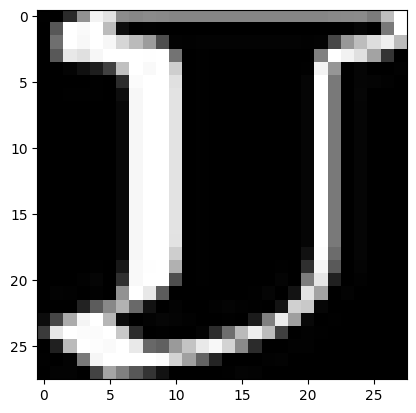

In [46]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()